# Flood risk exposure

Calculating population in flood risk zones (from JRC)

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [119]:
import ocha_stratus as stratus
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import geopandas as gpd
import pandas as pd
from rioxarray.exceptions import NoDataInBounds

from dask.diagnostics import ProgressBar

from src.datasources import codab, hydrosheds, worldpop
from src.constants import *
from src.utils.raster import (
    compute_density_from_grid,
    compute_pop_from_density,
)

## Load and process data

In [4]:
gdf_benue = hydrosheds.load_benue_aoi()

In [11]:
adm2 = codab.load_codab_from_blob(admin_level=2, aoi_only=True)
adm2 = adm2[adm2["ADM1_PCODE"] == ADAMAWA]
adm2_aoi = adm2[adm2["ADM2_PCODE"].isin(BENUE_ADM2_PCODES)]

In [8]:
da_wp = worldpop.load_raw_worldpop()
da_wp.attrs["_FillValue"] = np.nan

In [9]:
da_wp_adm = da_wp.rio.clip(adm2.geometry)

In [ ]:
blob_name = f"{PROJECT_PREFIX}/processed/jrc-floodhazard/ID125_N10_E10_RP10_depth_reclass.tif"
da_reclass = stratus.open_blob_cog(blob_name)

In [35]:
blob_name = (
    f"{PROJECT_PREFIX}/processed/jrc-floodhazard/ID125_N10_E10_RP10_depth.tif"
)
da_depth = stratus.open_blob_cog(blob_name)

In [36]:
da_depth_aoi = da_depth.rio.clip(adm2_aoi.geometry)

In [18]:
da_reclass_aoi = da_reclass.rio.clip(adm2_aoi.geometry)

In [21]:
with ProgressBar():
    da_reclass_aoi_computed = da_reclass_aoi.compute()

[########################################] | 100% Completed | 1.26 sms


In [37]:
with ProgressBar():
    da_depth_aoi_computed = da_depth_aoi.compute()

[########################################] | 100% Completed | 1.05 sms


## Test plotting

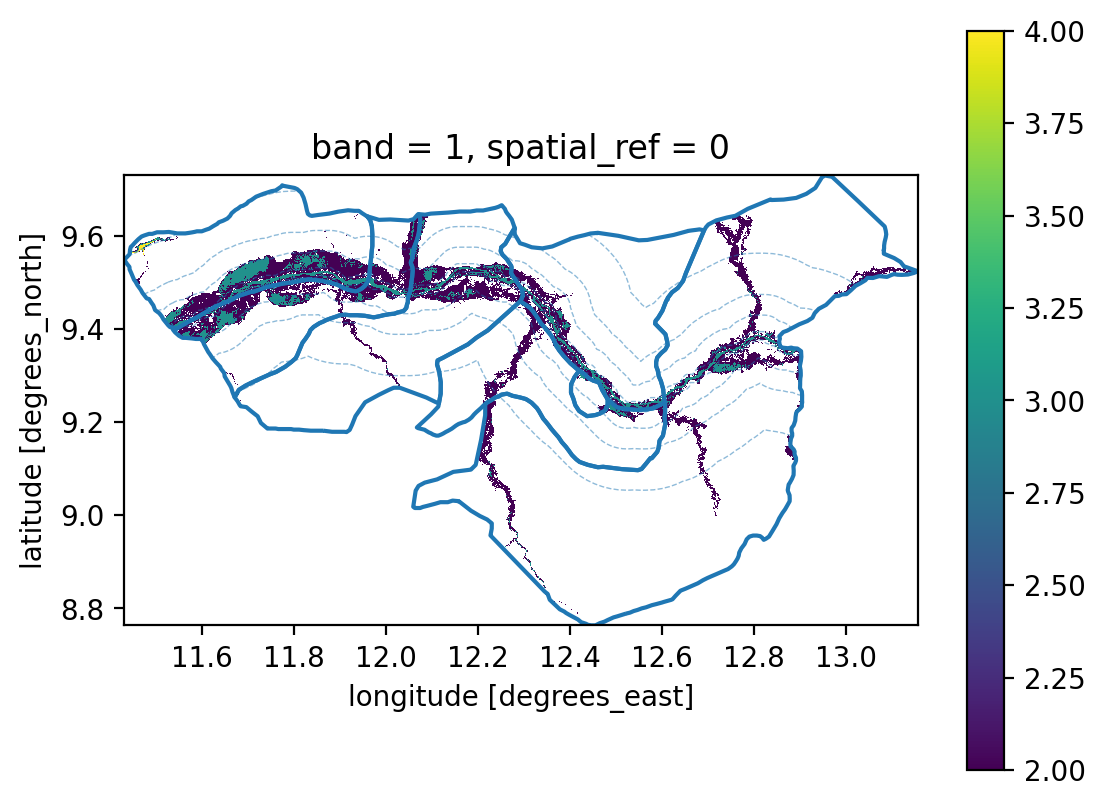

In [40]:
fig, ax = plt.subplots(dpi=200)
da_reclass_aoi_computed.where(da_reclass_aoi_computed > 0).plot(ax=ax)
adm2_aoi.boundary.plot(ax=ax)
adm2_union = adm2_aoi.union_all()
for buffer_km in [1, 5, 10, 20]:
    buffer_geom = gdf_benue.to_crs(3857).buffer(buffer_km * 1000).union_all()
    buffer_geom = (
        gpd.GeoSeries([buffer_geom], crs=3857).to_crs(4326).union_all()
    )
    buffer_boundary = buffer_geom.boundary
    clipped_boundary = buffer_boundary.intersection(adm2_union)
    if not clipped_boundary.is_empty:
        gpd.GeoSeries([clipped_boundary], crs=4326).plot(
            ax=ax, linewidth=0.5, linestyle="--", alpha=0.5
        )

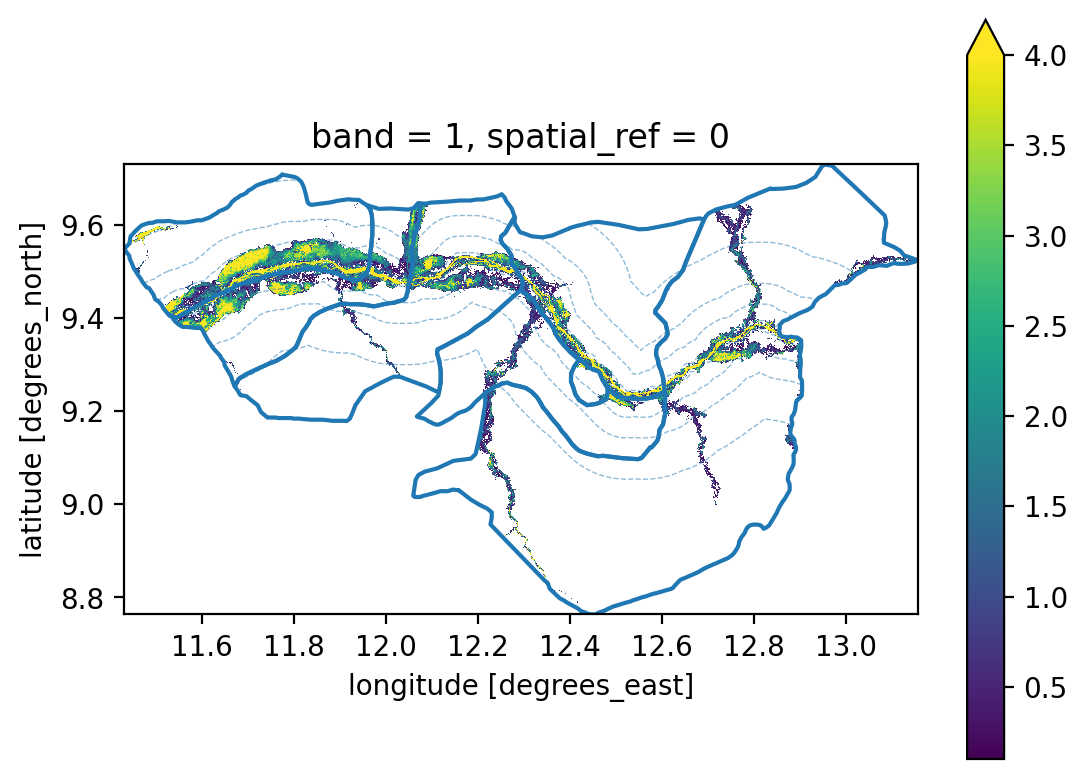

In [43]:
fig, ax = plt.subplots(dpi=200)
da_depth_aoi_computed.where(da_depth_aoi_computed > 0).plot(ax=ax, vmax=4)
adm2_aoi.boundary.plot(ax=ax)
adm2_union = adm2_aoi.union_all()
for buffer_km in [1, 5, 10, 20]:
    buffer_geom = gdf_benue.to_crs(3857).buffer(buffer_km * 1000).union_all()
    buffer_geom = (
        gpd.GeoSeries([buffer_geom], crs=3857).to_crs(4326).union_all()
    )
    buffer_boundary = buffer_geom.boundary
    clipped_boundary = buffer_boundary.intersection(adm2_union)
    if not clipped_boundary.is_empty:
        gpd.GeoSeries([clipped_boundary], crs=4326).plot(
            ax=ax, linewidth=0.5, linestyle="--", alpha=0.5
        )

In [45]:
da_density = compute_density_from_grid(da_wp_adm, lat_name="y", lon_name="x")

In [47]:
da_density_interp = da_density.interp_like(da_reclass_aoi_computed)

/Users/tdowning/.pyenv/versions/ds-aa-nga-flooding/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


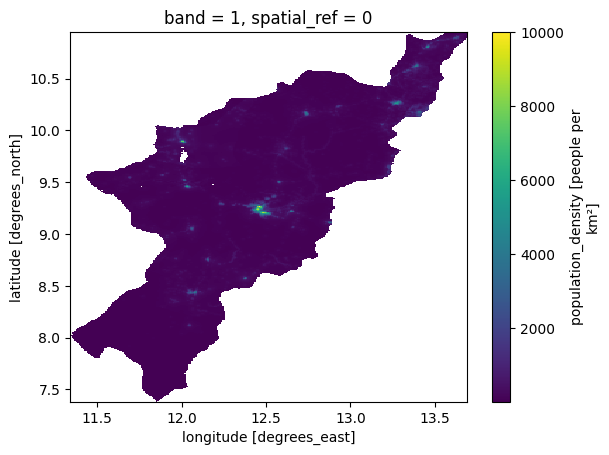

In [50]:
da_density.plot()

In [53]:
da_density_interp = da_density.rio.reproject_match(da_reclass_aoi_computed)

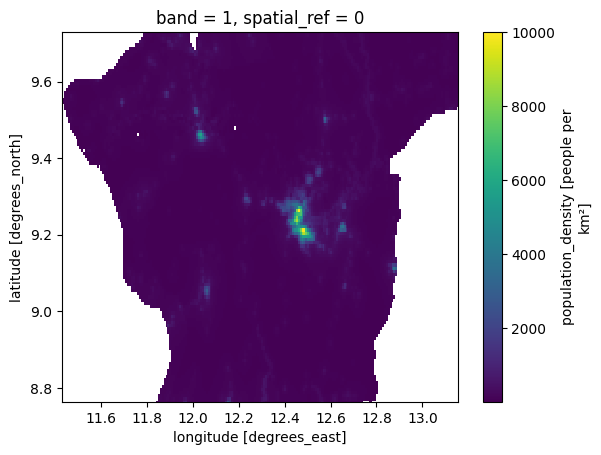

In [54]:
da_density_interp.plot()

In [60]:
da_pop_interp = compute_pop_from_density(
    da_density_interp, lat_name="y", lon_name="x"
)

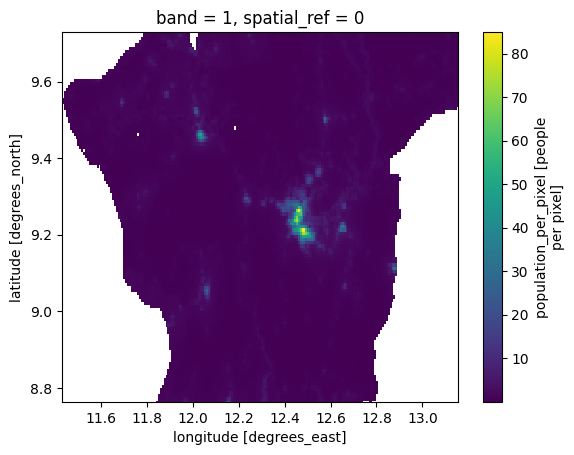

In [62]:
da_pop_interp.plot()

In [63]:
da_pop_interp.sum()

<xarray.DataArray 'population_per_pixel' ()> Size: 8B
array(1967037.96018411)
Coordinates:
    spatial_ref  int64 8B 0

In [71]:
da_wp_test = da_wp_adm.sel(
    x=slice(da_pop_interp["x"].min(), da_pop_interp["x"].max()),
    y=slice(da_pop_interp["y"].max(), da_pop_interp["y"].min()),
)

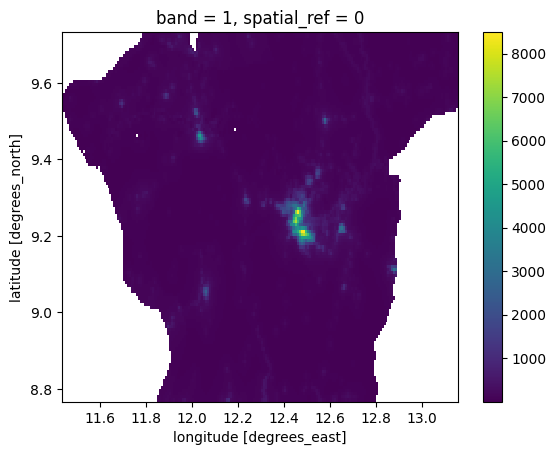

In [73]:
da_wp_test.plot()

In [74]:
da_wp_test.sum()

<xarray.DataArray ()> Size: 4B
array(1966877.8, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0

In [80]:
da_exp_reclass = da_pop_interp.where(da_reclass_aoi_computed > 0)

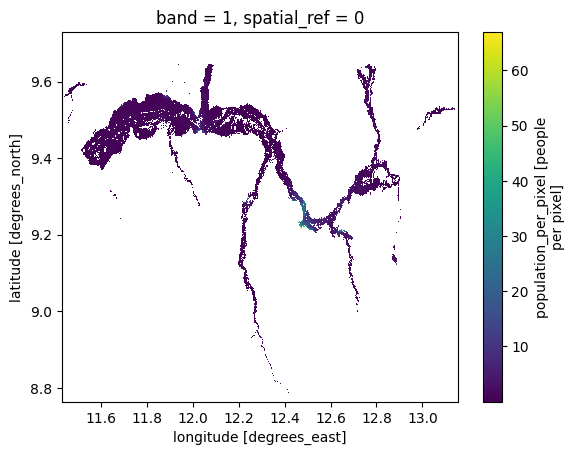

In [89]:
da_exp_reclass.plot()

In [86]:
da_exp_reclass_buffer = da_exp_reclass.rio.clip(
    gdf_benue.to_crs(3857).buffer(10 * 1000).to_crs(4326)
)

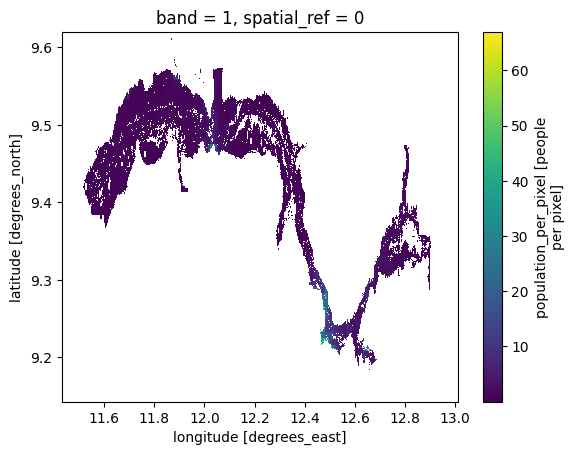

In [88]:
da_exp_reclass_buffer.plot()

In [101]:
dicts = []
for pcode, row in adm2.set_index("ADM2_PCODE").iterrows():
    try:
        da_clip = da_exp_reclass_buffer.rio.clip([row.geometry])
    except NoDataInBounds:
        continue
    pop = int(da_clip.sum())
    if pop < 1:
        continue
    dicts.append(
        {
            "ADM2_PCODE": pcode,
            "ADM2_EN": row["ADM2_EN"],
            "pop": pop,
        }
    )

In [102]:
df_exp = pd.DataFrame(dicts)

In [103]:
df_exp

,ADM2_PCODE,ADM2_EN,pop
0,NG002001,Demsa,15994
1,NG002002,Fufore,41333
2,NG002005,Girei,60133
3,NG002009,Lamurde,32790
4,NG002016,Numan,35714
5,NG002020,Yola North,15715
6,NG002021,Yola South,30472


In [104]:
df_exp.sum(numeric_only=True)

pop    232151
dtype: int64

In [105]:
blob_name = f"{PROJECT_PREFIX}/processed/adamawa_risk_10yr_rp_pop.csv"
stratus.upload_csv_to_blob(df_exp, blob_name)

In [106]:
blob_name = f"{PROJECT_PREFIX}/processed/adamawa_benue_buffer_pop.csv"
df_exp_adm = stratus.load_csv_from_blob(blob_name)

In [109]:
df_compare = df_exp.merge(df_exp_adm)

In [110]:
df_compare

,ADM2_PCODE,ADM2_EN,pop,pop_1km_buffer,pop_5km_buffer,pop_10km_buffer,pop_20km_buffer
0,NG002001,Demsa,15994,6369,33914,51665,73447
1,NG002002,Fufore,41333,22343,77203,145192,223624
2,NG002005,Girei,60133,56479,125612,164914,208615
3,NG002009,Lamurde,32790,10324,36409,73197,108555
4,NG002016,Numan,35714,15766,88531,110746,130581
5,NG002020,Yola North,15715,2195,144863,234307,234307
6,NG002021,Yola South,30472,337,114642,310625,375720


## Plots

In [112]:
df_plot = df_compare.copy()

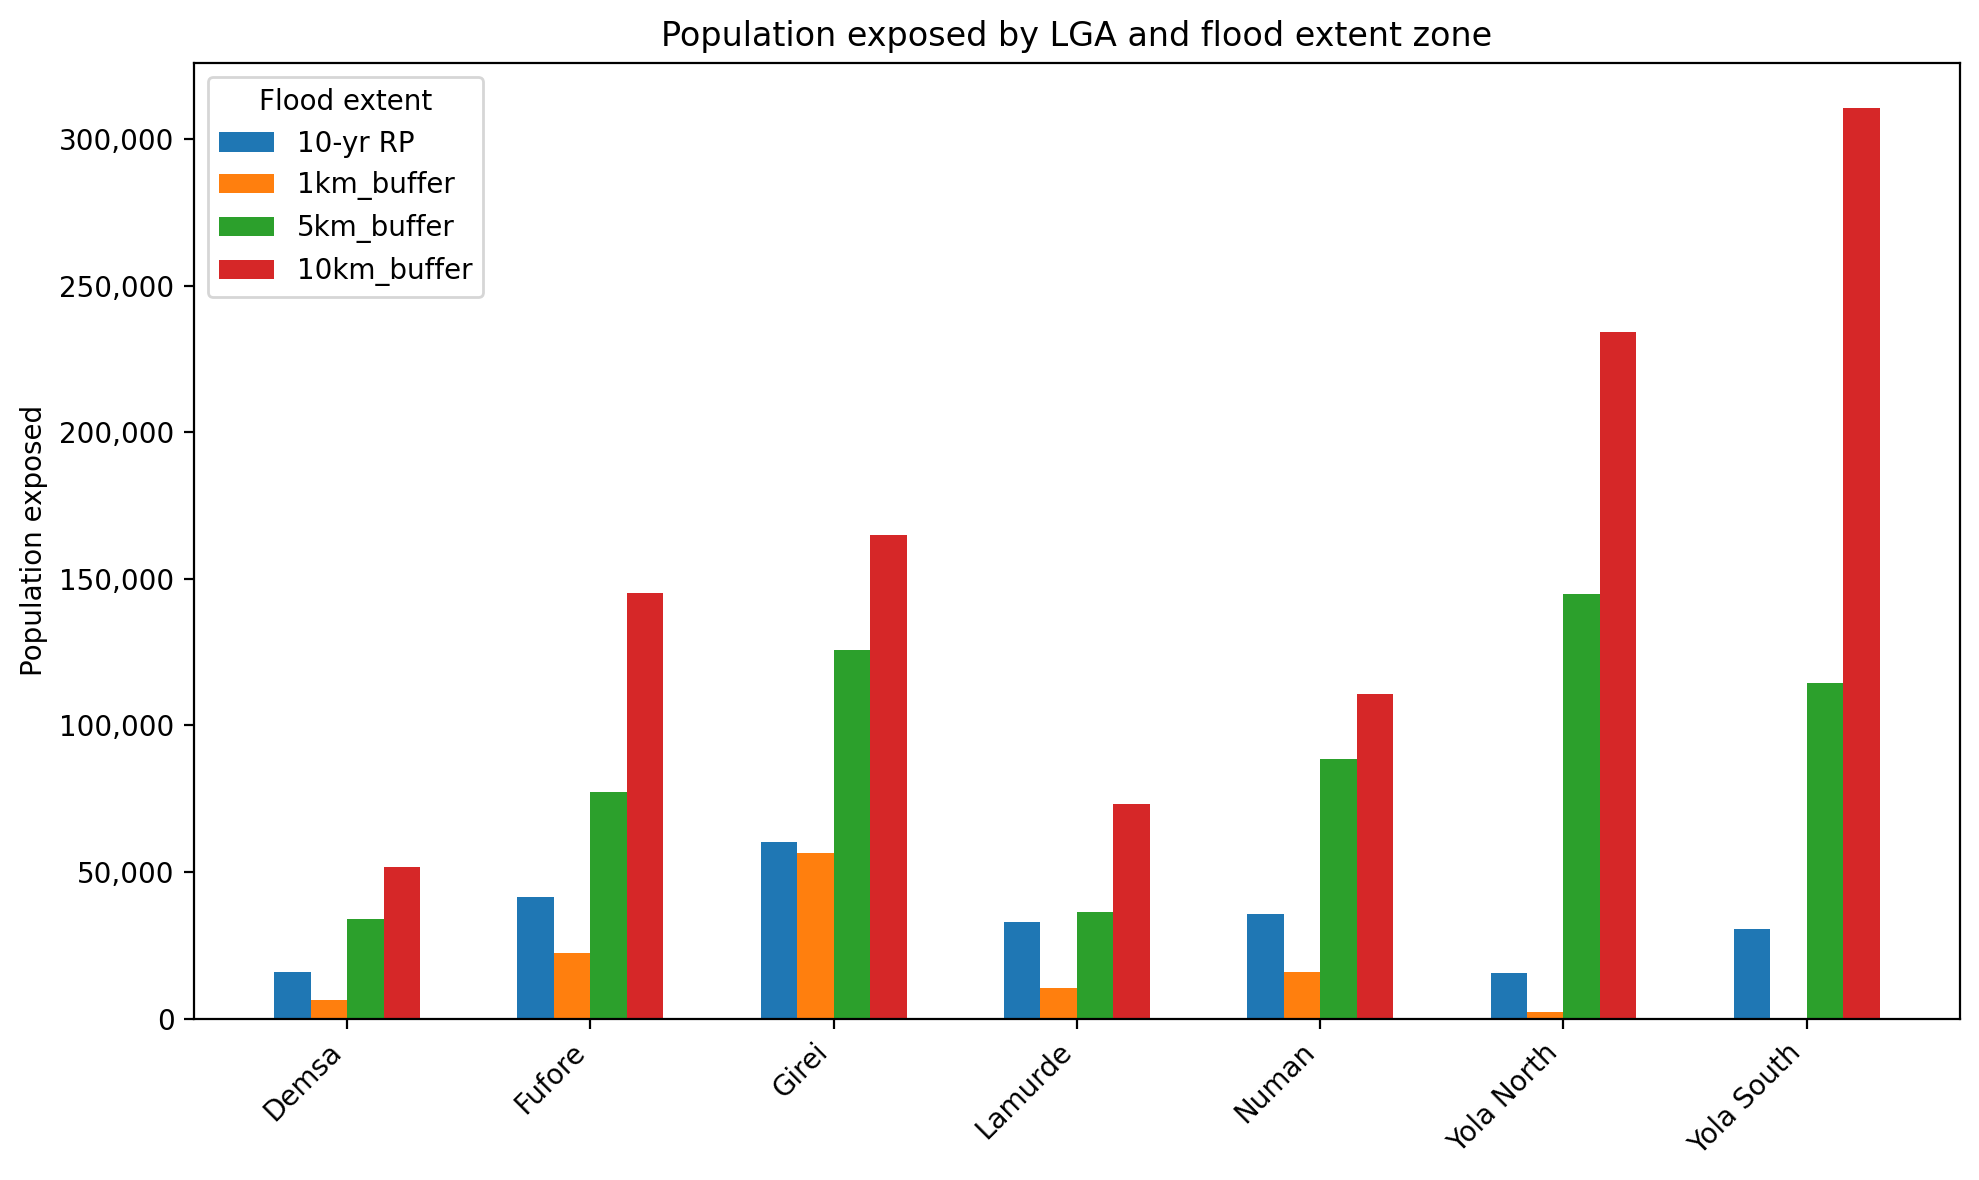

In [141]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

# Define population columns and x locations
pop_columns = ["pop", "pop_1km_buffer", "pop_5km_buffer", "pop_10km_buffer"]
x = np.arange(len(df_plot))
bar_width = 0.15

# Plot each population category
for i, col in enumerate(pop_columns):
    ax.bar(
        x + i * bar_width,
        df_plot[col],
        width=bar_width,
        label=col.replace("pop", "").strip("_") or "10-yr RP",
    )

# Set labels and ticks
ax.set_xticks(x + bar_width * (len(pop_columns) - 1) / 2)
ax.set_xticklabels(df_plot["ADM2_EN"], rotation=45, ha="right")
ax.set_ylabel("Population exposed")
ax.set_title("Population exposed by LGA and flood extent zone")
ax.legend(title="Flood extent")

ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Adamawa population distribution\nin 10-yr RP flood zone\nwith Benue river buffer at 10 km')

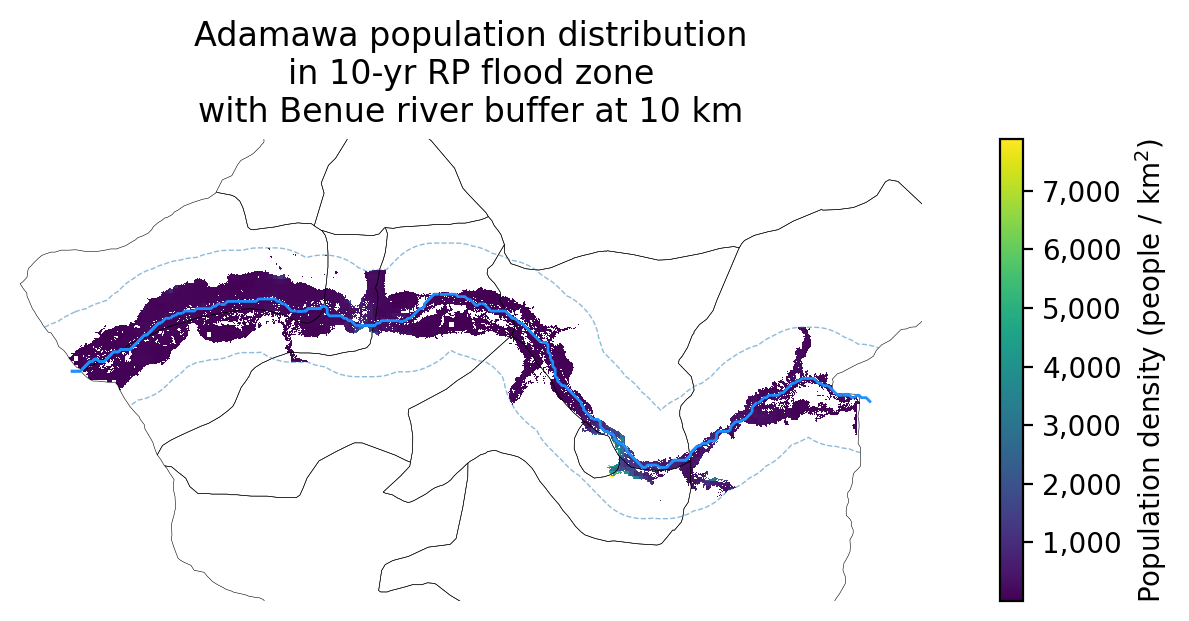

In [134]:
fig, ax = plt.subplots(dpi=200, figsize=(10, 3))
mappable = da_density_interp.where(da_exp_reclass_buffer >= 0).plot(
    ax=ax, add_colorbar=False
)

cbar = fig.colorbar(mappable, ax=ax, fraction=0.02)
cbar.ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f"{int(x):,}")
)
cbar.set_label("Population density (people / km$^2$)")
adm2.boundary.plot(linewidth=0.2, color="k", ax=ax)
gdf_benue.plot(linewidth=1, color="dodgerblue", ax=ax)
adm2_union = adm2.union_all()
buffer_kms = [10]
for buffer_km in buffer_kms:
    # Create merged buffer around Benue
    buffer_geom = gdf_benue.to_crs(3857).buffer(buffer_km * 1000).union_all()
    buffer_geom = (
        gpd.GeoSeries([buffer_geom], crs=3857).to_crs(4326).union_all()
    )

    # Get the boundary line
    buffer_boundary = buffer_geom.boundary

    # Clip the boundary to only the part that intersects ADM2
    clipped_boundary = buffer_boundary.intersection(adm2_union)

    # Plot (only if not empty)
    if not clipped_boundary.is_empty:
        gpd.GeoSeries([clipped_boundary], crs=4326).plot(
            ax=ax, linewidth=0.5, linestyle="--", alpha=0.5
        )

ax.axis("off")
ax.set_ylim(top=9.8, bottom=9)
ax.set_title(
    "Adamawa population distribution\n"
    "in 10-yr RP flood zone\n"
    "with Benue river buffer at "
    f"{', '.join([str(x) for x in buffer_kms])} km"
)